Imports

In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn import preprocessing

plt.rcParams['figure.figsize'] = [10, 5]

Read Data

In [227]:
raw_songs = pd.read_csv('taylor_swift_spotify.csv', index_col=0)

songs = raw_songs.drop(columns=['id', 'uri'])
songs.head()

,name,album,release_date,track_number,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,Welcome To New York (Taylor's Version),1989 (Taylor's Version) [Deluxe],2023-10-27,1,0.009420,0.757,0.610,0.000037,0.3670,-4.840,0.0327,116.998,0.685,66,212600
1,Blank Space (Taylor's Version),1989 (Taylor's Version) [Deluxe],2023-10-27,2,0.088500,0.733,0.733,0.000000,0.1680,-5.376,0.0670,96.057,0.701,67,231833
2,Style (Taylor's Version),1989 (Taylor's Version) [Deluxe],2023-10-27,3,0.000421,0.511,0.822,0.019700,0.0899,-4.785,0.0397,94.868,0.305,68,231000
3,Out Of The Woods (Taylor's Version),1989 (Taylor's Version) [Deluxe],2023-10-27,4,0.000537,0.545,0.885,0.000056,0.3850,-5.968,0.0447,92.021,0.206,67,235800
4,All You Had To Do Was Stay (Taylor's Version),1989 (Taylor's Version) [Deluxe],2023-10-27,5,0.000656,0.588,0.721,0.000000,0.1310,-5.579,0.0317,96.997,0.520,65,193289


Meaning of each variable: https://developer.spotify.com/documentation/web-api/reference/get-audio-features

Initial Plot

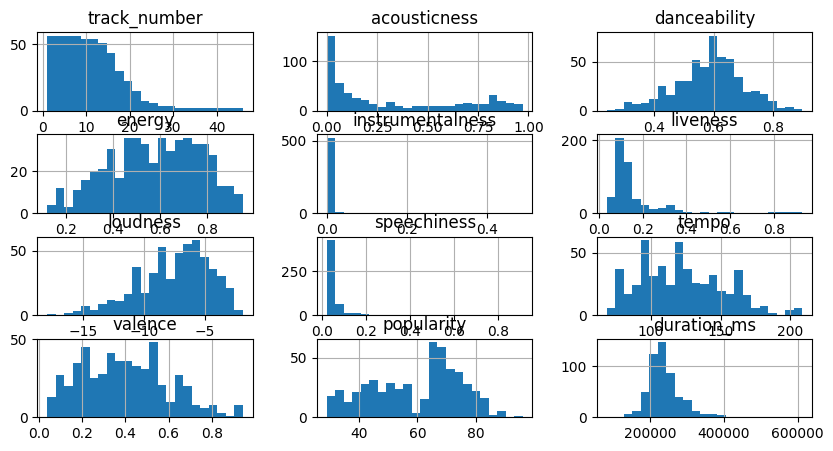

In [228]:
songs.hist(bins=23) 
plt.show()

Converting Release date to year as a float

In [229]:
songs['release_date'] = pd.to_datetime(songs['release_date'])

songs['release_date'] = songs['release_date'].dt.year + (songs['release_date'].dt.month - 1) / 12 + (songs['release_date'].dt.day - 1) / 365

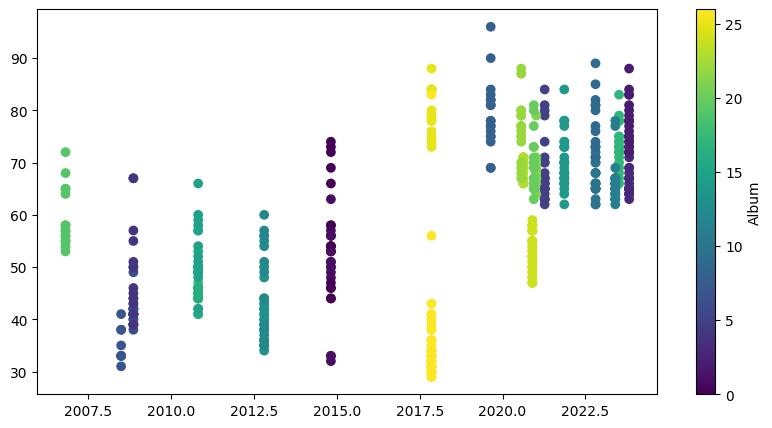

In [230]:
plt.scatter(songs['release_date'], songs['popularity'], c=songs['album'].astype('category').cat.codes)
plt.colorbar(label='Album')
plt.show()

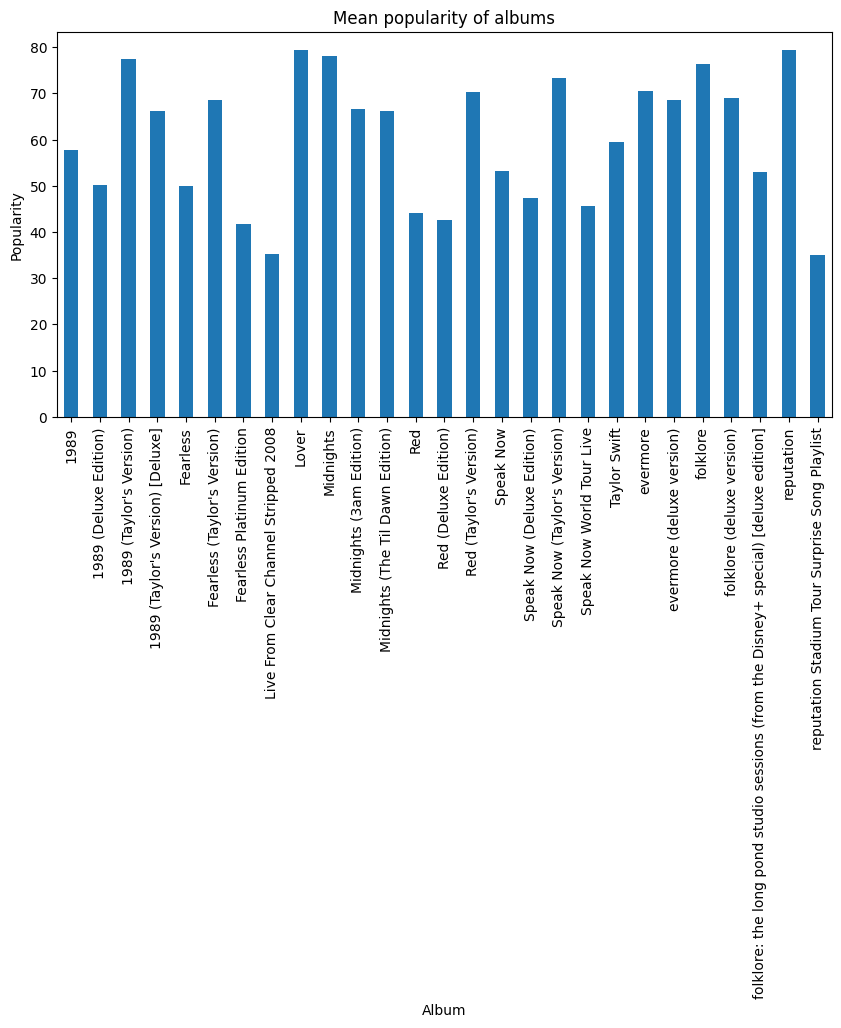

In [231]:
grouped_songs = songs.groupby('album')['popularity'].mean()
grouped_songs.plot(kind='bar')
plt.xlabel('Album')
plt.ylabel('Popularity')
plt.title('Mean popularity of albums')
plt.show()

Duration Scaling (from ms to s)

In [224]:
songs['duration_ms'] = songs['duration_ms'] / 1000
songs.rename(columns={'duration_ms': 'duration'}, inplace=True)

songs['duration'].head()

0    212.600
1    231.833
2    231.000
3    235.800
4    193.289
Name: duration, dtype: float64

In [ ]:
songs.dtypes


### Removing voice memo

Not songs, rather commentaries about the making off.

In [160]:
songs = songs[~songs.name.str.contains('Voice Memo')]

songs[songs.name.str.contains('Voice Memo')]

songs.to_csv('dropped_voice_memo.csv')

### Categorical Variables: taylor_version, not_first_release, live

#### Taylor's Version

In [161]:
songs['taylors_version'] = songs['name'].str.contains('Taylor\'s Version|Taylor’s Version')
songs['taylors_version'].value_counts()

taylors_version
False    406
True     121
Name: count, dtype: int64

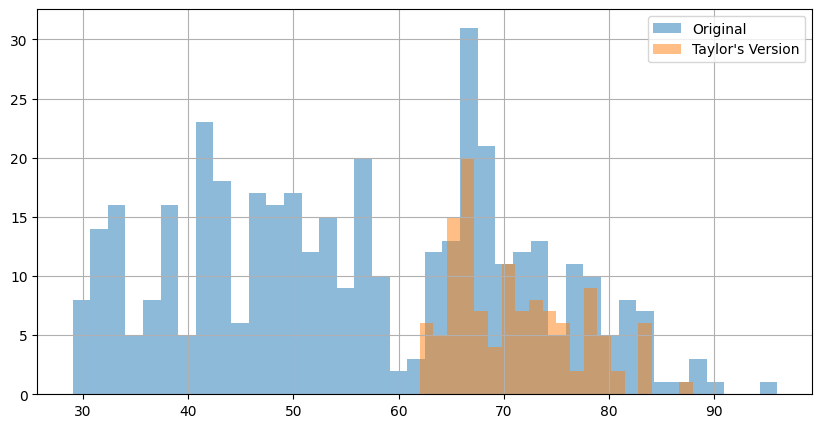

In [162]:
songs[songs['taylors_version'] == False]['popularity'].hist(bins=40, alpha=0.5)
songs[songs['taylors_version'] == True ]['popularity'].hist(bins=20, alpha=0.5)
plt.legend(['Original', 'Taylor\'s Version'])
plt.show()

#### Performed_live categorical variable

In [163]:
live_albums = ["Live From Clear Channel Stripped 2008", "Speak Now World Tour Live", "reputation Stadium Tour Surprise Song Playlist"]
songs['performed_live'] = songs['album'].isin(live_albums)

songs_without_live = songs[~songs['performed_live']]

songs['performed_live'].value_counts()

performed_live
False    457
True      70
Name: count, dtype: int64

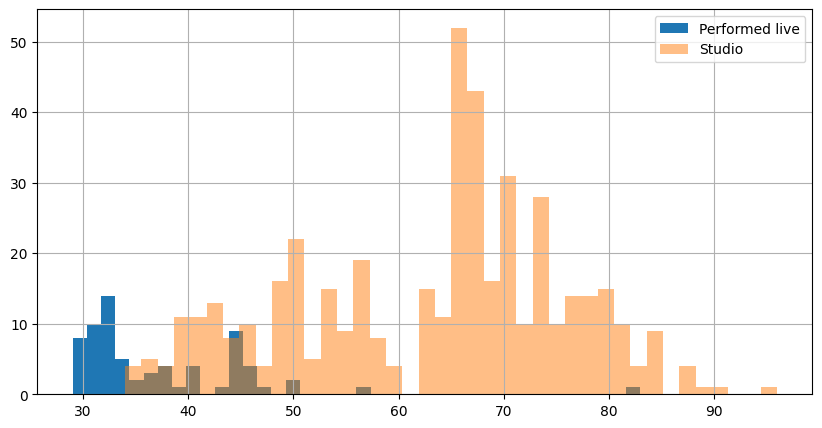

In [164]:
songs[songs['performed_live'] == True ]['popularity'].hist(bins=40, alpha=1)
songs[songs['performed_live'] == False]['popularity'].hist(bins=40, alpha=0.5)
plt.legend(['Performed live', 'Studio'])
plt.show()

Midnights

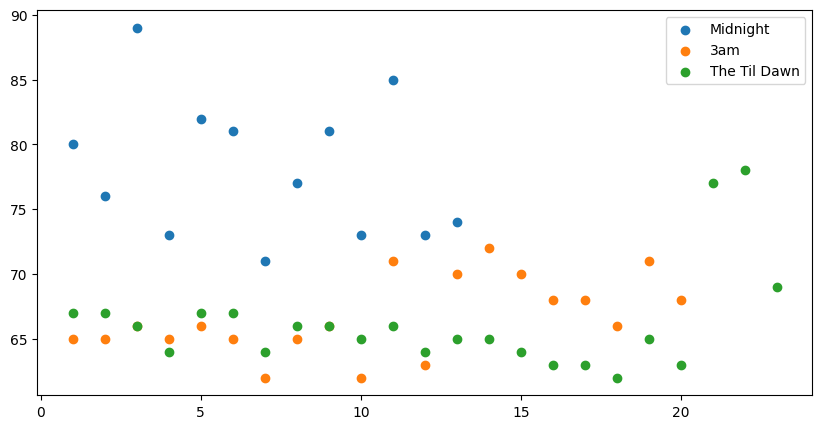

['Hits Different', 'Snow On The Beach (feat. More Lana Del Rey)', 'Karma (feat. Ice Spice)']


In [165]:
midnight = songs[songs['album'] == 'Midnights']
three_am = songs[songs['album'].str.contains('3am')]
til_the_dawn = songs[songs['album'].str.contains('The Til Dawn Edition')]

plt.scatter(midnight['track_number'], midnight['popularity'])
plt.scatter(three_am['track_number'], three_am['popularity'])
plt.scatter(til_the_dawn['track_number'], til_the_dawn['popularity'])
plt.legend(['Midnight', '3am', 'The Til Dawn'])
plt.show()

#songs.scatter(songs['album'], songs['popularity'])
from itertools import zip_longest
print( list(s1 for s2, s1 in zip_longest(three_am['name'], til_the_dawn['name']) if s1 != s2 ))

Folklore

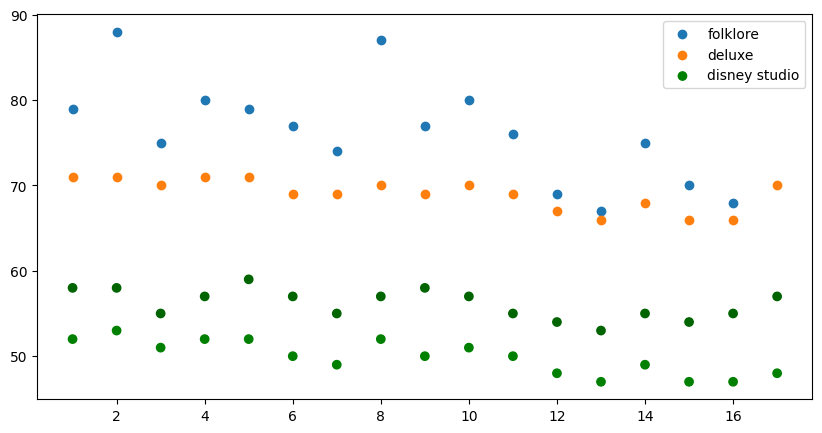

In [166]:

folklore = songs[songs['album'] == 'folklore']
deluxe = songs[songs['album'] == 'folklore (deluxe version)']
studio = songs[songs['album'] == 'folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]']

plt.scatter(folklore['track_number'], folklore['popularity'])
plt.scatter(deluxe['track_number'], deluxe['popularity'])
plt.scatter(studio['track_number'], studio['popularity'], c = ['green']* (len(studio)//2) + ['darkgreen']*(len(studio)//2))
plt.legend(['folklore', 'deluxe', 'disney studio'])
plt.show()

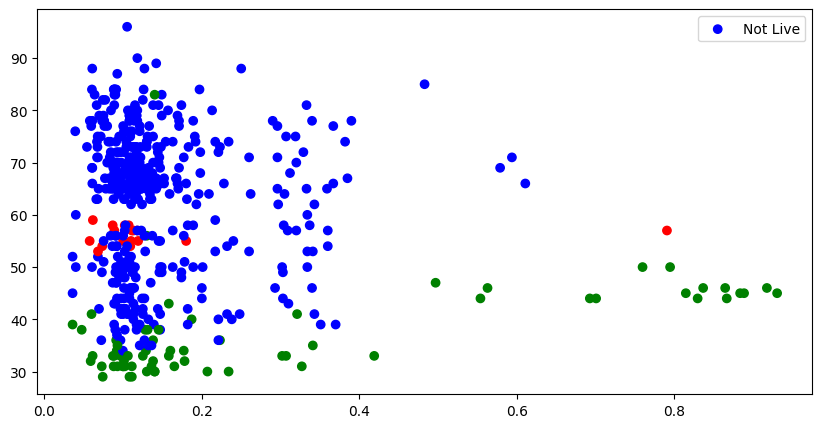

,name,album,release_date,track_number,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms,taylors_version,performed_live,len_name
226,the 1 - the long pond studio sessions,folklore: the long pond studio sessions (from ...,2020.899087,1,0.898,0.708,0.250,0.026000,0.1020,-10.731,0.0361,139.803,0.156,58,219893,False,False,37
227,cardigan - the long pond studio sessions,folklore: the long pond studio sessions (from ...,2020.899087,2,0.880,0.395,0.234,0.000000,0.1070,-9.704,0.0382,86.478,0.247,58,230680,False,False,40
228,the last great american dynasty - the long pon...,folklore: the long pond studio sessions (from ...,2020.899087,3,0.743,0.640,0.618,0.004000,0.0574,-11.715,0.0379,147.948,0.614,55,232346,False,False,63
229,exile (feat. Bon Iver) - the long pond studio ...,folklore: the long pond studio sessions (from ...,2020.899087,4,0.848,0.359,0.305,0.000067,0.1110,-10.295,0.0306,151.956,0.108,57,279893,False,False,54
230,my tears ricochet - the long pond studio sessions,folklore: the long pond studio sessions (from ...,2020.899087,5,0.946,0.531,0.172,0.000010,0.0615,-12.340,0.0351,129.007,0.168,59,295173,False,False,49
231,mirrorball - the long pond studio sessions,folklore: the long pond studio sessions (from ...,2020.899087,6,0.780,0.509,0.386,0.000034,0.1180,-8.434,0.0272,109.993,0.109,57,237373,False,False,42
232,seven - the long pond studio sessions,folklore: the long pond studio sessions (from ...,2020.899087,7,0.914,0.694,0.449,0.000126,0.1000,-11.490,0.0301,94.963,0.363,55,208986,False,False,37
233,august - the long pond studio sessions,folklore: the long pond studio sessions (from ...,2020.899087,8,0.500,0.554,0.663,0.000048,0.7910,-8.961,0.0324,89.977,0.545,57,260000,False,False,38
234,this is me trying - the long pond studio sessions,folklore: the long pond studio sessions (from ...,2020.899087,9,0.928,0.435,0.332,0.000898,0.0867,-11.611,0.0310,68.097,0.157,58,209293,False,False,49
235,illicit affairs - the long pond studio sessions,folklore: the long pond studio sessions (from ...,2020.899087,10,0.883,0.489,0.235,0.000000,0.1130,-10.274,0.0356,117.699,0.435,57,183720,False,False,47


In [191]:
a = songs['name'].str.contains('the long pond')# & songs['track_number'] > 17
b = songs['performed_live']



# if the song is in a, the color is 'red'
# if the songs is in b, the color is 'green'
# othrewise the color is 'blue'

colors = ['red' if x else 'green' if y else 'blue' for x, y in zip(a, b)]


plt.scatter(songs['liveness'], songs['popularity'], c=colors)
plt.legend(['Not Live', 'Live', 'the long pond'])
plt.show()

songs[a]

We leave the songs as this (don't need to merge) with only a not_first_release indicator.

In [14]:
first_release_indexes = songs.groupby('name').apply(lambda group: group.index.max())

songs['not_first_release'] = songs.index != songs['name'].map(first_release_indexes)
songs['not_first_release'] &= ~songs['performed_live']

# problem with the long pond: all should be True
songs.loc[songs['album'].str.contains('the long pond'), 'not_first_release'] = True

# songs[songs['album'].str.contains('1989 (', regex=False)][['name', 'album', 'not_first_release']]
# songs.loc[songs['album'].str.contains('the long pond'), 'not_first_release']

C:\Users\mique\AppData\Local\Temp\ipykernel_8992\2091704739.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_release_indexes = songs.groupby('name').apply(lambda group: group.index.max())


In [15]:
name = 'Midnights (Deluxe Edition)'
name = name[:len('Midnights')].rstrip()
name
songs['album'].value_counts()

album
reputation Stadium Tour Surprise Song Playlist                                         46
folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]    34
Red (Taylor's Version)                                                                 30
Fearless (Taylor's Version)                                                            26
Midnights (The Til Dawn Edition)                                                       23
1989 (Taylor's Version) [Deluxe]                                                       22
Speak Now (Taylor's Version)                                                           22
Red (Deluxe Edition)                                                                   22
1989 (Taylor's Version)                                                                21
Midnights (3am Edition)                                                                20
Speak Now (Deluxe Edition)                                                             20
Fear

In [16]:
# songs.loc[songs['album'].str.contains('(Deluxe Edition)'), 'album'] 
songs['album'] = songs['album'].apply(lambda name: name[:-len('(Deluxe Edition)')].rstrip() if '(Deluxe Edition)' in name else name)
songs['album'] = songs['album'].apply(lambda name: name[:-len('Platinum Edition')].rstrip() if 'Platinum Edition' in name else name)
songs['album'] = songs['album'].apply(lambda name: name[:-len('[Deluxe]')].rstrip() if '[Deluxe]' in name else name)
songs['album'] = songs['album'].apply(lambda name: name[:-len('(deluxe version)')].rstrip() if '(deluxe version)' in name else name)
# songs['album'] = songs['album'].apply(lambda name: 'Midnights' if 'Midnights' in name else name)
songs.loc[songs['album'].str.contains('Midnights'), 'album'] = 'Midnights'
# songs['album'] = songs['album'].apply(lambda name: 'folklore' if 'folklore' in name else name)
songs.loc[songs['album'].str.contains('folklore'), 'album'] = 'folklore'

# songs['album'] = songs['album'].apply(lambda name: name[:len('(Taylor\'s Version)')].rstrip() if '(Taylor\'s Version)' in name else name) 
# si volem unificar Taylor's Version això
# Pensa però que s'ha d'anar en compte perquè hi ha una distància temporal molt gran entre Taylor's Version i les originals.

songs['album'].value_counts()


album
folklore                                          67
Midnights                                         56
reputation Stadium Tour Surprise Song Playlist    46
1989 (Taylor's Version)                           43
Red                                               38
Speak Now                                         34
Fearless                                          32
evermore                                          32
Red (Taylor's Version)                            30
1989                                              29
Fearless (Taylor's Version)                       26
Speak Now (Taylor's Version)                      22
Lover                                             18
Speak Now World Tour Live                         16
reputation                                        15
Taylor Swift                                      15
Live From Clear Channel Stripped 2008              8
Name: count, dtype: int64

### Correlation of variables

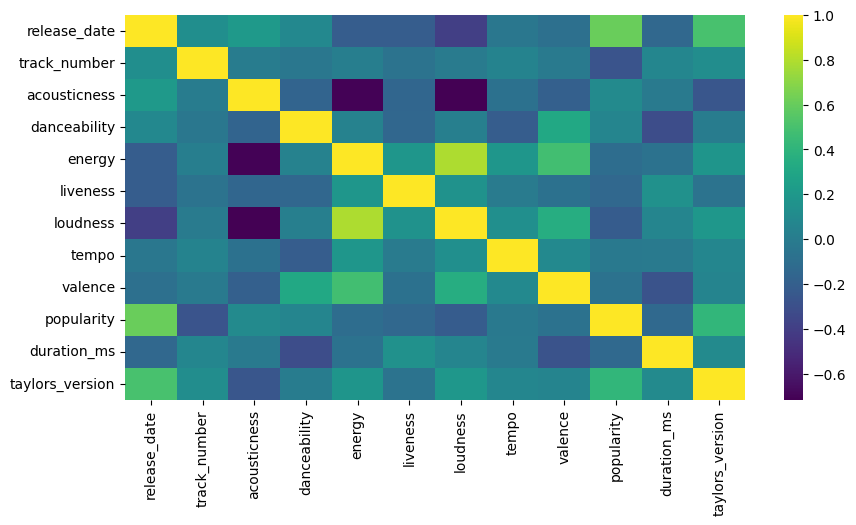

In [220]:
idx = [i for i in range(2,14)] # numeric data
corr = songs.iloc[:, idx].corr()
sns.heatmap(corr, cmap='viridis')  # Change the cmap parameter to 'viridis' for a different color palette
plt.show()

Problemes: veiem com acousticness, danceability, enrgy i loudness estan totes relacionades entre elles. A més a més, relase_date i popularity fortament correlades (ja ho sabíem).

### Popularity vs time:

Popularity vs time

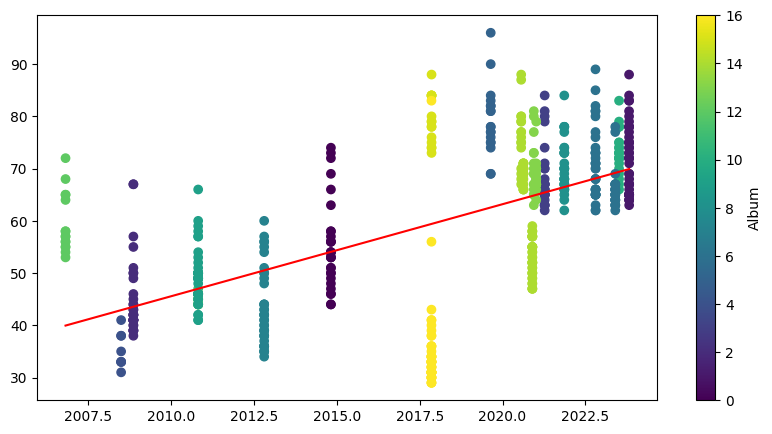

1.7619623268353404 -3495.9791890539886


In [18]:

# Scatter plot
plt.scatter(songs['release_date'], songs['popularity'], c=songs['album'].astype('category').cat.codes)
plt.colorbar(label='Album')

# Linear regression line
x = songs['release_date']
y = songs['popularity']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')

plt.show()
print(m, b)

Difference from regression line in popularity vs time 

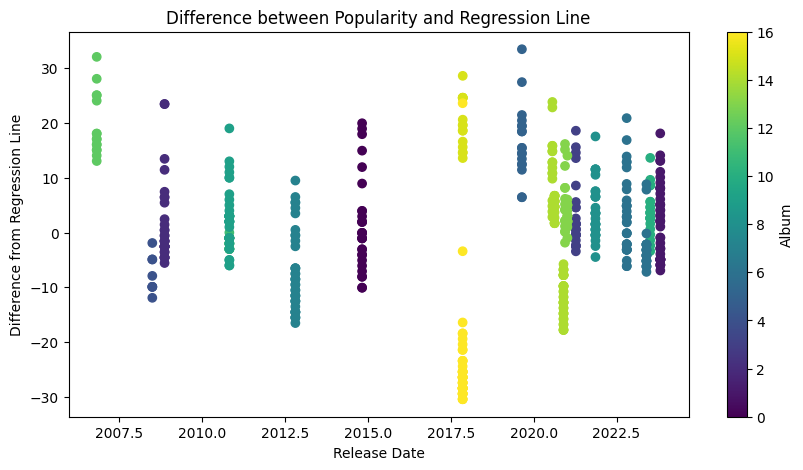

In [19]:
# Scatter plot
plt.scatter(x, y - (m*x + b), c=songs['album'].astype('category').cat.codes)
plt.colorbar(label='Album')

plt.xlabel('Release Date')
plt.ylabel('Difference from Regression Line')
plt.title('Difference between Popularity and Regression Line')
plt.show()


Popularity vs time without live performances

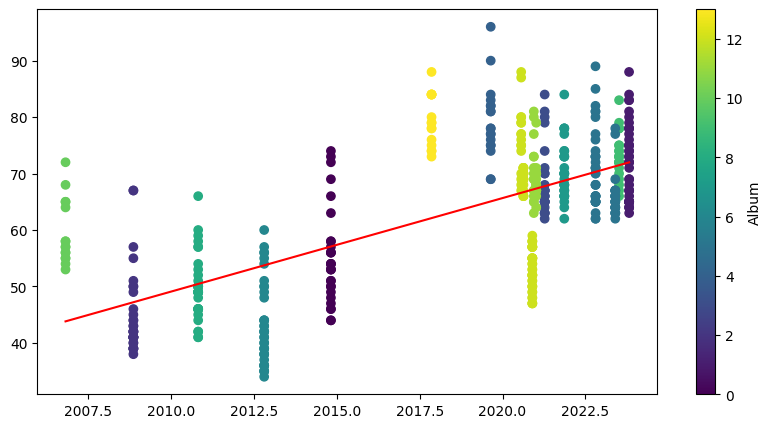

1.6561814155755255 -3279.831071424405


In [20]:

songs_without_live = songs[songs['performed_live'] == False]

# Scatter plot
plt.scatter(songs_without_live['release_date'], songs_without_live['popularity'], c=songs_without_live['album'].astype('category').cat.codes)
plt.colorbar(label='Album')

# Linear regression line
x1 = songs_without_live['release_date']
y1 = songs_without_live['popularity']
m, b = np.polyfit(x1, y1, 1)
plt.plot(x1, m*x1 + b, color='red')

plt.show()
print(m, b)

### Popularity vs mean by album

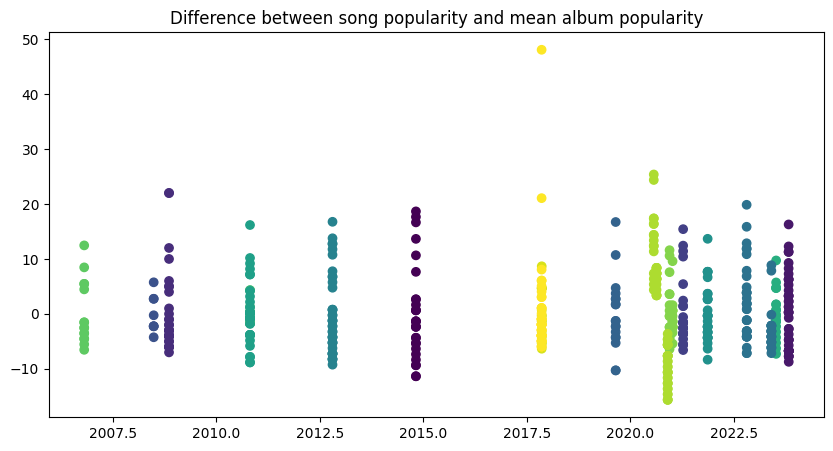

In [21]:
albums = songs.groupby('album')['popularity'].mean()

plt.scatter(songs['release_date'], songs['popularity'] - albums[songs['album']].values, c=songs['album'].astype('category').cat.codes)
plt.title("Difference between song popularity and mean album popularity")
plt.show()

#### Solving relase_date and popularity correlation:

the variable release_date contains vairability that is very hard to explain if we want to create a model that predicst popularity with only the parameters established earlier. Therefore, we have to delete it

In [225]:
songs.drop(columns=['release_date'], inplace=True)

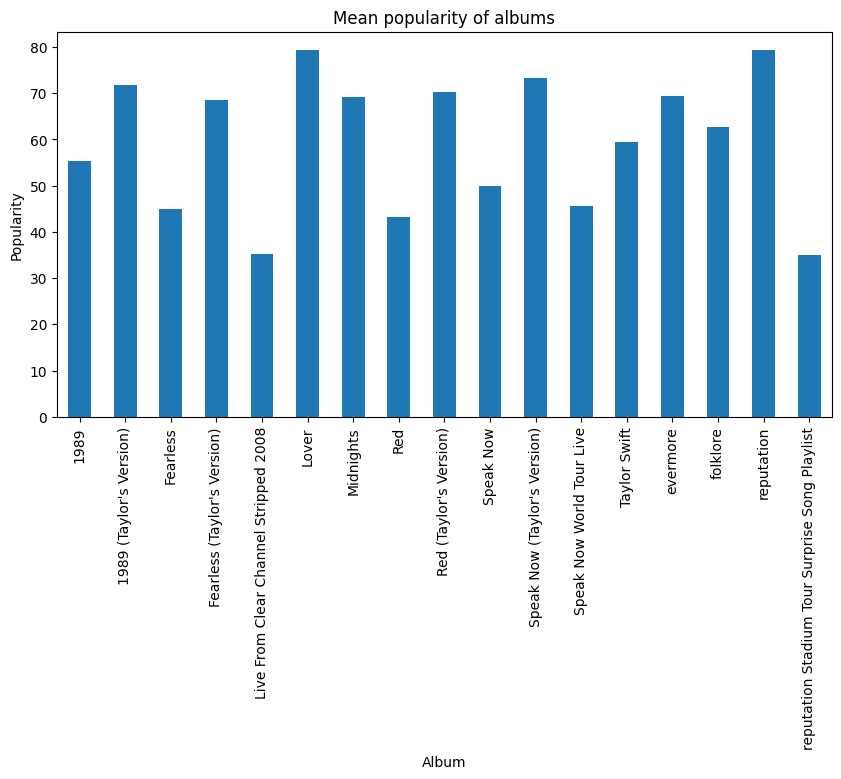

In [23]:
grouped_songs = songs.groupby('album')['popularity'].mean()
grouped_songs.plot(kind='bar')
plt.xlabel('Album')
plt.ylabel('Popularity')
plt.title('Mean popularity of albums')
plt.show()

### Track Number

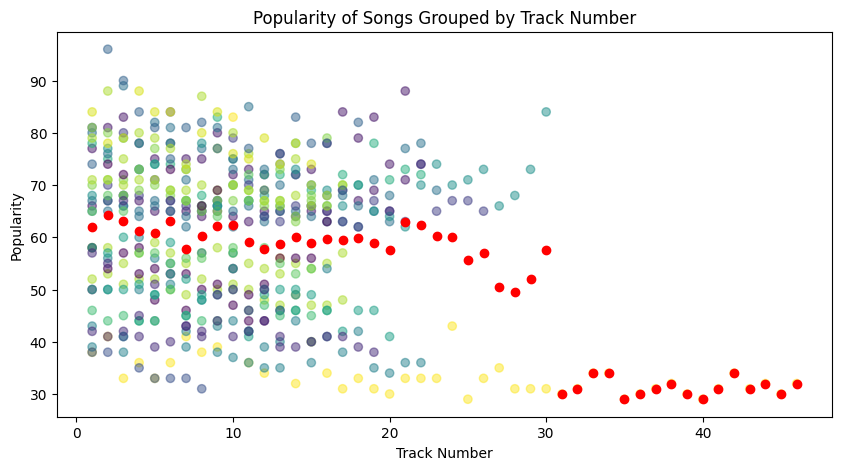

In [24]:
plt.scatter(songs['track_number'], songs['popularity'], c=songs['album'].astype('category').cat.codes, alpha=0.5)

grouped_songs = songs.groupby('track_number')['popularity'].mean()

plt.scatter(grouped_songs.index, grouped_songs.values, c='red')
plt.xlabel('Track Number')
plt.ylabel('Popularity')
plt.title('Popularity of Songs Grouped by Track Number')
plt.show()

### Checking datatypes

In [25]:
songs.dtypes

name                  object
album                 object
track_number           int64
acousticness         float64
danceability         float64
energy               float64
instrumentalness     float64
liveness             float64
loudness             float64
speechiness          float64
tempo                float64
valence              float64
popularity             int64
duration_ms            int64
taylors_version         bool
performed_live          bool
not_first_release       bool
dtype: object

### Feature Scaling and Normalization of data

Popularity scaling

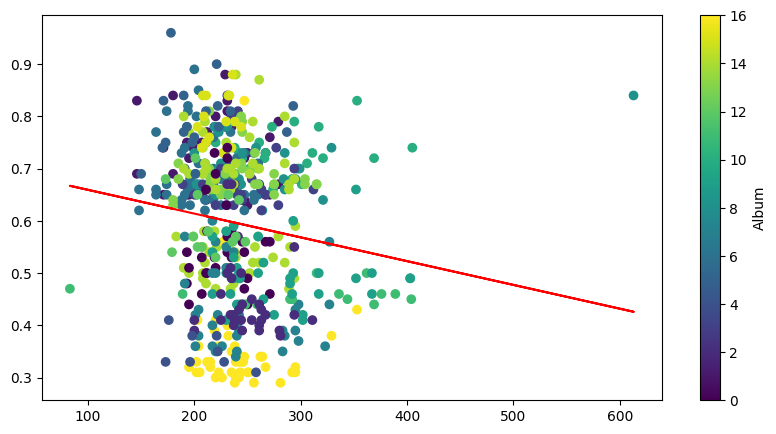

-0.00045494524987328315 0.7048251234150332


In [29]:

# popularity vs duration
plt.scatter(songs_scaled['duration'], songs_scaled['popularity'], c = songs['album'].astype('category').cat.codes)
plt.colorbar(label='Album')

# Linear regression line
x = songs_scaled['duration']
y = songs_scaled['popularity']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')

plt.show()
print(m, b)

# NO té sentit categoritzar 'duration': per exemple 'short', 'average', 'long'




In [30]:
# # Scatter plot
# plt.scatter(songs_scaled['release_date'], songs_scaled['duration'])

# # Linear regression line
# x = songs_scaled['release_date']
# y = songs_scaled['duration']
# m, b = np.polyfit(x, y, 1)
# plt.plot(x, m*x + b, color='red')

# plt.show()
# print(m, b)


We see that the duration of songs remains constant over time. We can't see a clear correlation between the song being 'short', 'medium' or 'long', so we might prefer to keep duration as a numeric variable instead of a categorical one.

Danceability, tempo, energy are all very correlated: we might try to create a new variable that combines them

We saw earlirer that these variables are correlated together, so in a future we might do future engineering to join them into a single one.

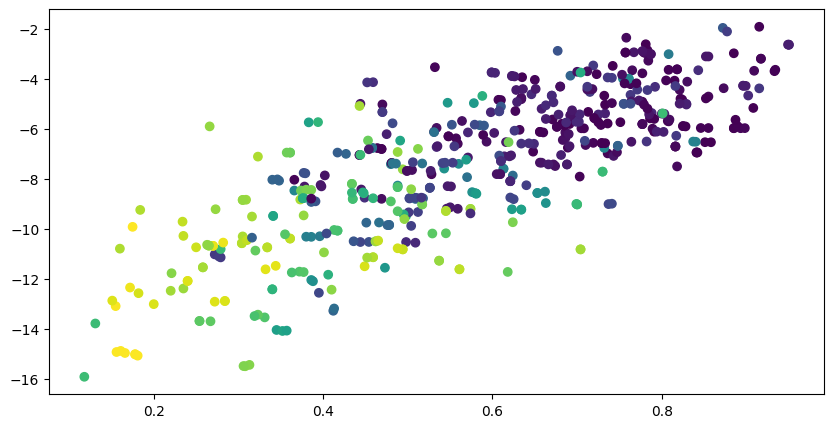

In [31]:
plt.scatter(songs_scaled['energy'], songs_scaled['loudness'], c = songs_scaled['acousticness'])
plt.show()

Instrumentalness

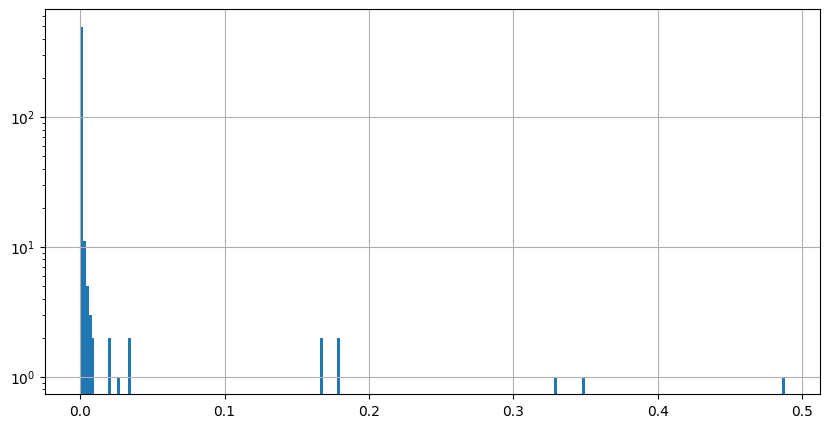

In [32]:
songs['instrumentalness'].hist(bins=250, log=True)

plt.show()

In [33]:
songs[songs['instrumentalness'] > 0.04]['instrumentalness']

74     0.328
97     0.348
117    0.488
179    0.166
188    0.179
196    0.166
205    0.179
Name: instrumentalness, dtype: float64

In [199]:
songs['low_instrumentalness'] = (songs['instrumentalness'] >= 0.05) & (songs['instrumentalness'] < 0.25)
songs['medium_instrumentalness'] = (songs['instrumentalness'] >= 0.25)
songs.drop(columns=['instrumentalness'], inplace=True)

print(songs['low_instrumentalness'].value_counts(), '\n')
print(songs['medium_instrumentalness'].value_counts())

low_instrumentalness
False    523
True       4
Name: count, dtype: int64 

medium_instrumentalness
False    524
True       3
Name: count, dtype: int64


Valence

,name,album,release_date,track_number,acousticness,danceability,energy,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms,taylors_version,performed_live,len_name,low_instrumentalness,medium_instrumentalness
360,Shake It Off,1989 (Deluxe Edition),2014.821233,6,0.0647,0.647,0.800,0.334,-5.384,0.165,160.078,0.942,53,219200,False,False,12,False,False
379,Shake It Off,1989,2014.821233,6,0.0561,0.647,0.785,0.148,-5.414,0.165,160.015,0.943,73,219200,False,False,12,False,False


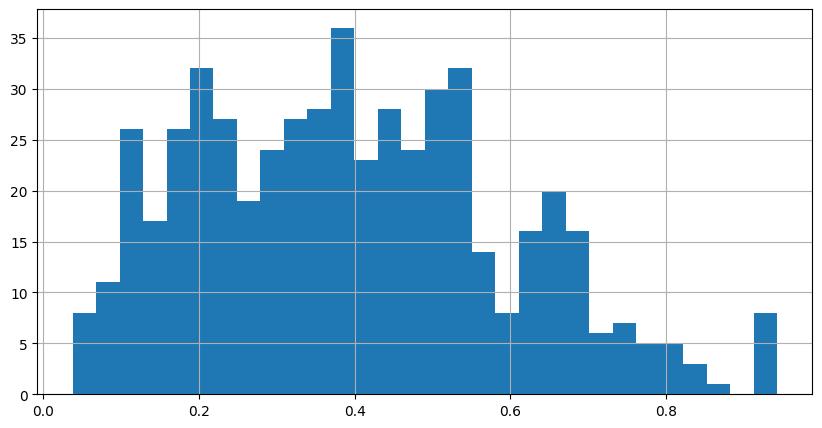

In [200]:
songs['valence'].hist(bins = 30)
songs.loc[songs['valence'] > 0.93]

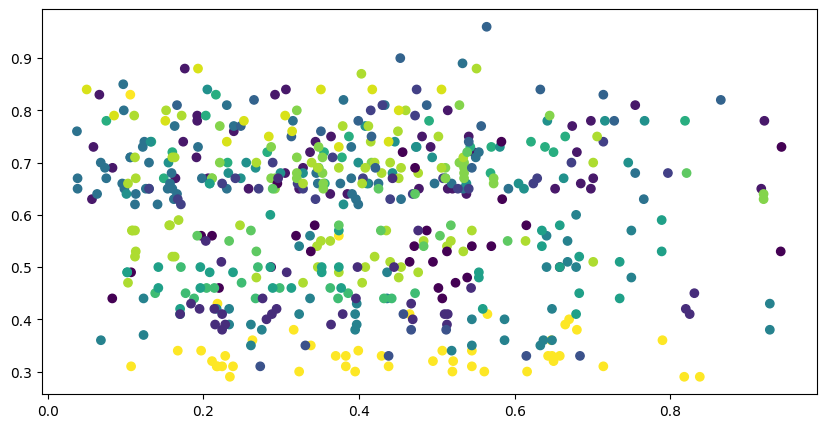

In [201]:

plt.scatter(songs_scaled['valence'], songs_scaled['popularity'], c=songs_scaled['album'].astype('category').cat.codes)
plt.show()

Tempo

<Axes: >

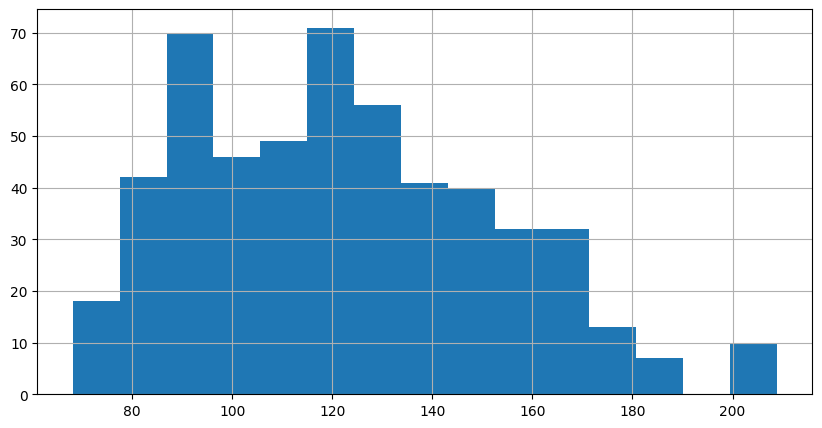

In [202]:
songs['tempo'].hist(bins = 15)

,name,album,track_number,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,taylors_version,performed_live,not_first_release,duration
142,Better Man (Taylor's Version) (From The Vault),Red (Taylor's Version),22,0.2140,0.473,0.579,0.000000,0.0877,-5.824,0.0384,73.942,0.255,0.70,True,False,False,297
181,tolerate it,evermore,5,0.8780,0.316,0.361,0.000027,0.0797,-10.381,0.0488,74.952,0.221,0.70,False,False,True,245
198,tolerate it,evermore,5,0.8780,0.316,0.361,0.000027,0.0797,-10.381,0.0488,74.952,0.221,0.77,False,False,False,245
234,this is me trying - the long pond studio sessions,folklore,9,0.9280,0.435,0.332,0.000898,0.0867,-11.611,0.0310,68.097,0.157,0.58,False,False,True,209
278,Lover,Lover,3,0.4920,0.359,0.543,0.000016,0.1180,-7.582,0.0919,68.534,0.453,0.90,False,False,False,221
292,It’s Nice To Have A Friend,Lover,17,0.9710,0.737,0.175,0.000337,0.1710,-9.912,0.0401,70.008,0.545,0.69,False,False,False,150
300,So It Goes...,reputation,7,0.1220,0.574,0.610,0.000001,0.1300,-7.283,0.0732,74.957,0.374,0.73,False,False,True,227
321,So It Goes...,reputation Stadium Tour Surprise Song Playlist,13,0.1220,0.574,0.610,0.000001,0.1300,-7.283,0.0732,74.957,0.374,0.56,False,True,False,227
341,Breathe,reputation Stadium Tour Surprise Song Playlist,33,0.4160,0.442,0.480,0.000000,0.1290,-7.405,0.0281,73.849,0.167,0.34,False,True,False,264
500,Breathe,Fearless,7,0.3790,0.505,0.482,0.000000,0.1130,-7.372,0.0276,73.975,0.184,0.43,False,False,False,263


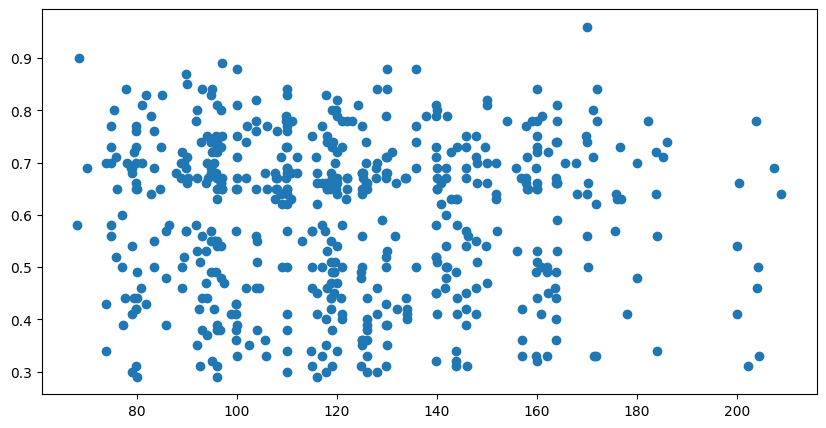

In [203]:
plt.scatter(songs_scaled['tempo'], songs_scaled['popularity'])

songs_scaled.loc[songs_scaled['tempo'] < 75]


Speechiness

<Axes: >

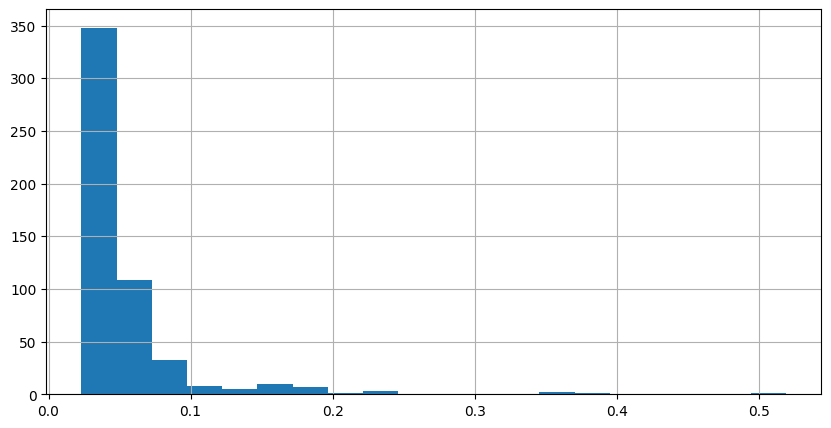

In [204]:
songs['speechiness'].hist(bins = 20)

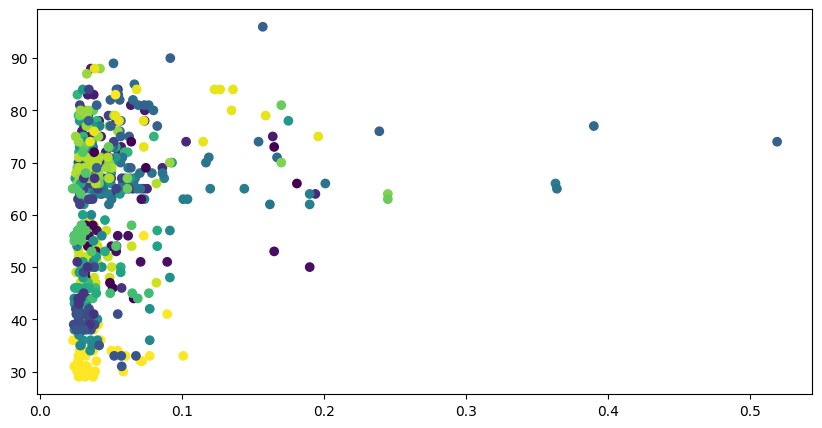

In [205]:
plt.scatter(songs['speechiness'], songs['popularity'], c=songs['album'].astype('category').cat.codes)

In [206]:
songs['spoken_section'] = songs['speechiness'] > 0.33 
songs.drop(columns=['speechiness'], inplace=True)

In [207]:
songs[songs['spoken_section']]

,name,album,release_date,track_number,acousticness,danceability,energy,liveness,loudness,tempo,valence,popularity,duration_ms,taylors_version,performed_live,len_name,low_instrumentalness,medium_instrumentalness,spoken_section
72,Vigilante Shit,Midnights (The Til Dawn Edition),2023.401826,8,0.157,0.867,0.272,0.1180,-11.014,79.962,0.157,66,164801,False,False,14,False,False,True
95,Vigilante Shit,Midnights (3am Edition),2022.807534,8,0.160,0.870,0.279,0.1210,-11.134,79.996,0.160,65,164801,False,False,14,False,False,True
115,Vigilante Shit,Midnights,2022.804795,8,0.173,0.798,0.277,0.1210,-11.096,79.846,0.163,77,164801,False,False,14,False,False,True
276,I Forgot That You Existed,Lover,2019.643607,1,0.298,0.664,0.316,0.0812,-10.345,92.875,0.541,74,170640,False,False,25,False,False,True


### Standarizing variables

In [208]:
# print all variable types:

songs.dtypes

name                        object
album                       object
release_date               float64
track_number                 int64
acousticness               float64
danceability               float64
energy                     float64
liveness                   float64
loudness                   float64
tempo                      float64
valence                    float64
popularity                   int64
duration_ms                  int64
taylors_version               bool
performed_live                bool
len_name                     int64
low_instrumentalness          bool
medium_instrumentalness       bool
spoken_section                bool
dtype: object

In [219]:
# standarize variables
st_songs = songs.copy()
for col in songs.columns:
    if col == 'popularity':
        standard_songs[col] = songs[col] / 100
        continue

    if songs[col].dtype in ['float64', 'int64']:
        min = songs[col].min()
        max = songs[col].max()
        standard_songs[col] = (songs[col] - min) / (max - min)

# Min Max transformation
# min_max_transformer = preprocessing.minMax???



# Box-Cox transofrmation
st_songs['track_number'], _= boxcox(songs['track_number'])
st_songs['acousticness'], _= boxcox(songs['acousticness'])
st_songs['liveness'], _= boxcox(songs['liveness'])
        

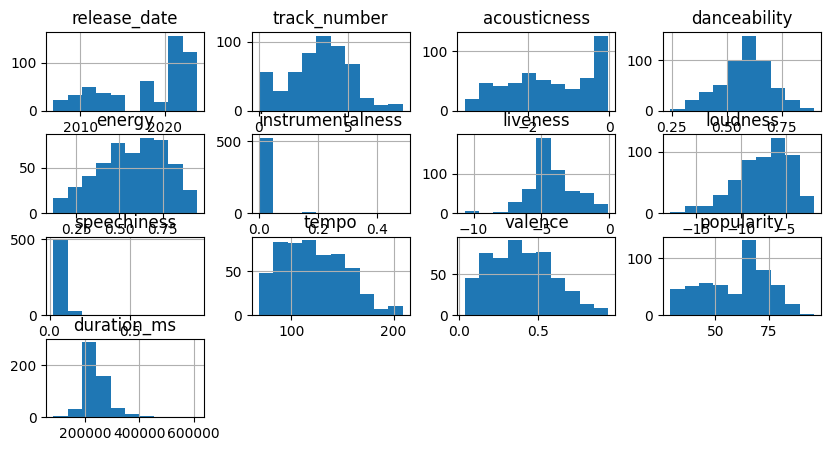

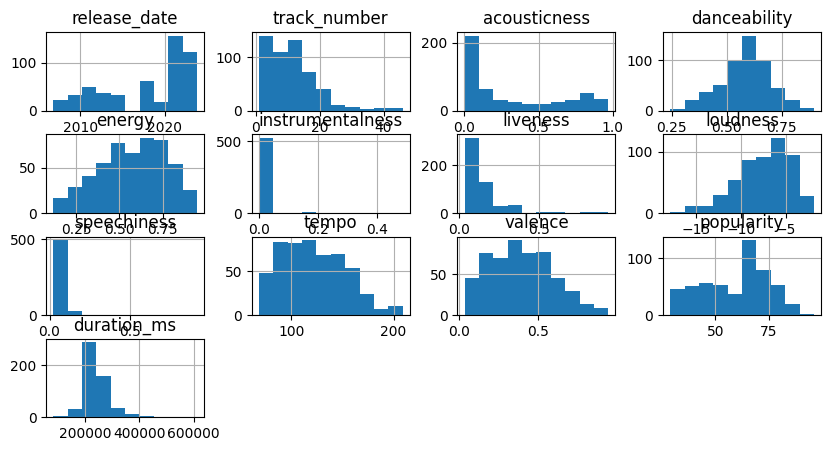

In [236]:
st_songs = songs.copy()
st_songs['track_number'], _= boxcox(songs['track_number'])
st_songs['acousticness'], _= boxcox(songs['acousticness'])
st_songs['liveness'], _= boxcox(songs['liveness'])

st_songs.hist()
songs.hist()
plt.show()

In [211]:
live_songs = songs[songs['performed_live']]
max_popularity = live_songs['popularity'].max()
songs_with_max_popularity = live_songs[live_songs['popularity'] == max_popularity]
songs_with_max_popularity

,name,album,release_date,track_number,acousticness,danceability,energy,liveness,loudness,tempo,valence,popularity,duration_ms,taylors_version,performed_live,len_name,low_instrumentalness,medium_instrumentalness,spoken_section
318,I Don’t Wanna Live Forever (Fifty Shades Darker),reputation Stadium Tour Surprise Song Playlist,2017.855251,10,0.0586,0.731,0.445,0.14,-8.418,117.97,0.106,83,247160,False,True,48,False,False,False
